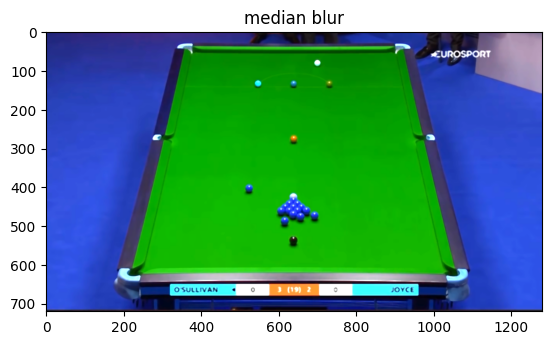

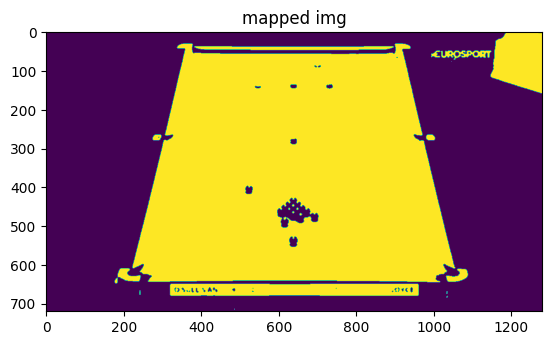

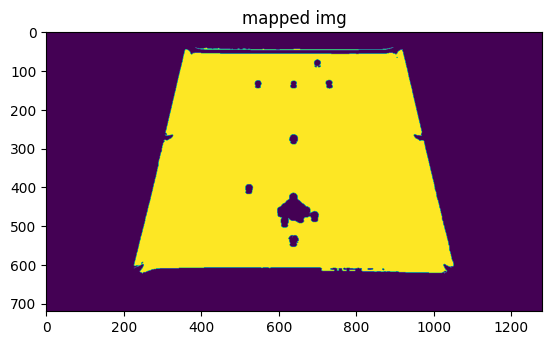

In [88]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
cv2.destroyAllWindows()
image_path = 'test_image.PNG'  

image = cv2.imread(image_path)

# make all color more pure and more contrast
# This make more clear edges

def custom_median_blur(image, kernel_size):
    padded_image = np.pad(image, ((kernel_size//2, kernel_size//2), (kernel_size//2, kernel_size//2), (0, 0)), mode='reflect')
    result = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                result[i, j, k] = np.median(padded_image[i:i+kernel_size, j:j+kernel_size, k])
    return result

def custom_convert_scale_abs(image, alpha, beta):
    result = alpha * image + beta
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

image = custom_median_blur(image, 5)
image = custom_convert_scale_abs(image, 1.5, 0)

plt.imshow(image)
plt.title('median blur')
plt.show()

# now map to gray scale but only with 2 colors
# more blue more black more green more white
def map_to_gray(image):
    avg_color = np.mean(image, axis=(0, 1))
    threshold = avg_color[1]
    gray_mapped = np.where(image[..., 1] > threshold, 255, 0)
    return gray_mapped.astype(np.uint8)

# map to gray in proportion to the green channel, more green more white
def map_to_gray2(image):
    # Compute the average value for each color channel
    avg_red = np.mean(image[:, :, 0])
    avg_green = np.mean(image[:, :, 1])
    avg_blue = np.mean(image[:, :, 2])

    # Create a mask where green is higher than average and red and blue are below their averages
    mask = (image[:, :, 1] > avg_green) & (image[:, :, 0] < avg_red) & (image[:, :, 2] < avg_blue)

    # Apply the mask to set selected pixels to white, others to black
    gray_mapped = np.where(mask, 255, 0)

    # Return the resulting image
    return gray_mapped.astype(np.uint8)


image_2 = image.copy()
image_2 = map_to_gray(image_2)

plt.imshow(image_2)
plt.title('mapped img')
plt.show()


image = map_to_gray2(image)
plt.imshow(image)
plt.title('mapped img')
plt.show()




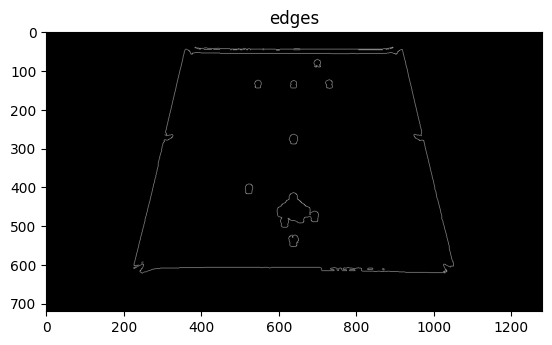

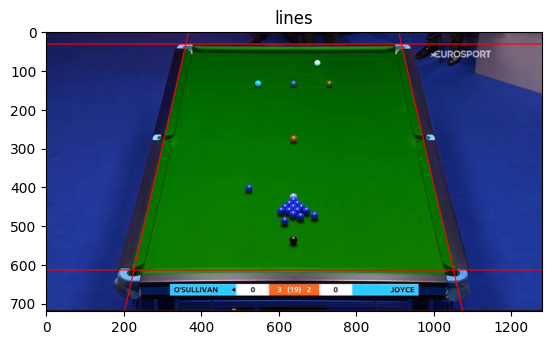

In [90]:
# find edge with  cv2.Canny and plot
edges = cv2.Canny(image, 100, 200)
plt.imshow(edges, cmap='gray')
plt.title('edges')
plt.show()

from scipy.ndimage import convolve


## ####################################
## ########## SOBEL FILTERS ###########
## ########## HOUGH LINES  ############
## ####################################

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
    
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = np.clip(G / G.max() * 255, 0, 255) 
    theta = np.arctan2(Iy, Ix)
    
    return G, theta


def hough_lines(edges, threshold, min_theta, max_theta, rho_resolution, theta_resolution):
    height, width = edges.shape
    diagonal = np.sqrt(height**2 + width**2)

    theta_angles = np.arange(min_theta, max_theta, theta_resolution)
    rho_values = np.linspace(-diagonal, diagonal, int(2 * diagonal / rho_resolution) + 1)

    num_thetas = len(theta_angles)
    num_rhos = len(rho_values)
    accumulator = np.zeros((num_rhos, num_thetas))

    sins = np.sin(theta_angles)
    coss = np.cos(theta_angles)

    y_idxs, x_idxs = np.where(edges > 0)

    for x, y in zip(x_idxs, y_idxs):
        for idx in range(num_thetas):

            rho = x * coss[idx] + y * sins[idx]
            rho_index = np.argmin(np.abs(rho_values - rho))
            accumulator[rho_index, idx] += 1

    idx_rhos, idx_thetas = np.where(accumulator > threshold)
    final_rhos = rho_values[idx_rhos]
    final_thetas = theta_angles[idx_thetas]

    polar_coordinates = np.column_stack((final_rhos, final_thetas))
    return polar_coordinates



G, theta = sobel_filters(image)

rho_resolution = 1
theta_resolution = np.pi / 180
min_theta = 0
max_theta = np.pi
threshold = 100 



## ####################################
## #####SPLIT VERTICAL AND HORIZ ######
## ####################################

# select only vertical lines
def filter_vertical_lines(lines, angle_threshold_deg):
    vertical_lines = []
    horizonal_lines = []
    angle_threshold_rad = np.radians(angle_threshold_deg)
    min_theta = np.pi/2 - angle_threshold_rad
    max_theta = np.pi/2 + angle_threshold_rad
    vertical_lines = [line for line in lines if min_theta <= line[1] <= max_theta]
    horizonal_lines = [line for line in lines if min_theta > line[1] or line[1] > max_theta]
    return np.array(vertical_lines), np.array(horizonal_lines)

lines = hough_lines(edges, threshold, min_theta, max_theta, rho_resolution, theta_resolution)
horizontal_lines , veritcal_line= filter_vertical_lines(lines, 20)


def adjust_lines_to_horizontal(lines):
    adjusted_lines = []
    for rho, theta in lines:
        x0 = rho * np.cos(theta)
        y0 = rho * np.sin(theta)
        new_rho = y0 
        adjusted_lines.append((new_rho, np.pi / 2))
        
    return np.array(adjusted_lines)

horizontal_lines = adjust_lines_to_horizontal(horizontal_lines)




## ####################################
#  ##### FILTER TO GET ONLY 4 LINES ###
## ####################################
# get the horizontal line that have  min y at x = 0
# get the horizontal line that have  max y at x = 0

def get_min_max_y_horizontal_lines(lines):
    min_y = np.inf
    max_y = -np.inf
    min_y_line = None
    max_y_line = None
    for rho, theta in lines:
        x0 = rho * np.cos(theta)
        y0 = rho * np.sin(theta)
        if y0 < min_y:
            min_y = y0
            min_y_line = (rho, theta)
        if y0 > max_y:
            max_y = y0
            max_y_line = (rho, theta)
    return min_y_line, max_y_line

min_y_line, max_y_line = get_min_max_y_horizontal_lines(horizontal_lines)
horizontal_lines = np.array([min_y_line, max_y_line])

# get the vertical line that have  min x at y = 0
# get the vertical line that have  max x at y = 0

def get_min_max_x_vertical_lines(lines):
    min_x = np.inf
    max_x = -np.inf
    min_x_line = None
    max_x_line = None
    for rho, theta in lines:
        x0 = rho * np.cos(theta)
        y0 = rho * np.sin(theta)
        if x0 < min_x:
            min_x = x0
            min_x_line = (rho, theta)
        if x0 > max_x:
            max_x = x0
            max_x_line = (rho, theta)
    return min_x_line, max_x_line

min_x_line, max_x_line = get_min_max_x_vertical_lines(veritcal_line)
veritcal_line = np.array([min_x_line, max_x_line])


# merge lines
lines = np.concatenate((horizontal_lines, veritcal_line), axis=0)





## ####################################
## ########         PLOT         ######
## ####################################
image_real = cv2.imread(image_path)

def plot_lines(image, lines, size_line=3000):
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + size_line * (-b))
        y1 = int(y0 + size_line * (a))
        x2 = int(x0 - size_line * (-b))
        y2 = int(y0 - size_line * (a))
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plot_lines(image_real, lines)
plt.imshow(image_real)
plt.title('lines')
plt.show()


## ####################################
## ####################################
## ####################################




Intersection Point 1: (226.10, 614.45)
Intersection Point 2: (360.22, 33.50)
Intersection Point 3: (917.62, 33.50)
Intersection Point 4: (1051.74, 614.45)


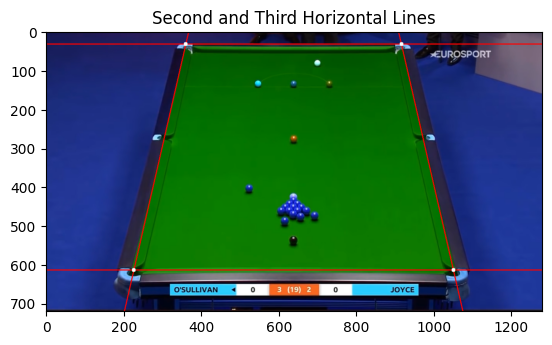

In [91]:
# COMPUTE INTERSECTION POINTS



# Compute intersection points
# every line is defined ρ = x * cos(θ) + y * sin(θ)
# so we can write it as A * x = b
# our system is A x = b
# | cos(θ1) sin(θ1) | x | =  | ρ1 |
# | cos(θ2) sin(θ2) | y |  = | ρ2 |

intersection_points = []
for rho1, theta1 in horizontal_lines:
    for rho2, theta2 in veritcal_line:
        A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
        b = np.array([rho1, rho2])
        intersection_point = np.linalg.solve(A, b)
        intersection_points.append(intersection_point)

# Sort point to manage more easily
intersection_points.sort(key=lambda x: x[0])
intersection_points_pos = []



## #################################
## #################################

image_path = 'test_image.PNG'  

output_image = cv2.imread(image_path)

# JUST VISUALIZATION
# PLOT LINES AND INTERSECTION POINTS
plot_lines(output_image, lines)

i = 0
for intersection_point in intersection_points:
    x, y = intersection_point
    print(f'Intersection Point {i + 1}: ({x:.2f}, {y:.2f})')
    intersection_points_pos.append((x, y))
    cv2.circle(output_image, (int(x), int(y)), 5, (255, 255, 255), -1)
    i += 1


plt.imshow(output_image)
plt.title('Second and Third Horizontal Lines')
plt.show()

## #################################
## #################################


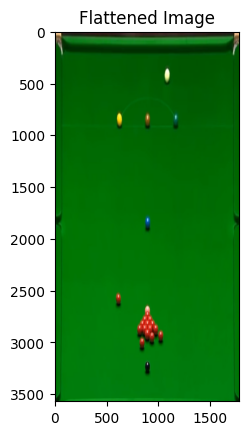

In [105]:
# #################################
# #################################
# JUST VISUALIZATION TO CHECK IF INTERSECTION POINTS ARE CORRECT

cv2.destroyAllWindows()
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


A = (0,3.569)
B = (0, 0)
C = (1.778,0)
D = (1.778, 3.569)

A = (A[0] * 1000, A[1] * 1000)
B = (B[0] * 1000, B[1] * 1000)
C = (C[0] * 1000, C[1] * 1000)
D = (D[0] * 1000, D[1] * 1000)

pts1 = np.float32([A,B,C,D])
pts2 = np.float32(intersection_points_pos)

# build the transformation matrix without cv2.getPerspectiveTransform
def find_prespective_transform(pts1, pts2):
    A = np.zeros((8, 9))
    for i in range(4):
        x, y = pts1[i]
        u, v = pts2[i]
        A[i * 2] = [x, y, 1, 0, 0, 0, -u * x, -u * y, -u]
        A[i * 2 + 1] = [0, 0, 0, x, y, 1, -v * x, -v * y, -v]
    U, S, V = np.linalg.svd(A)
    M = V[-1].reshape(3, 3)
    return M



from PIL import Image

def manual_warp_perspective(image_in, M, out_h, out_w):
    image = image_in.copy()

    output_image = np.zeros((out_h, out_w, 3), dtype=np.uint8)
    
    M_inv = np.linalg.inv(M)
    height, width, _ = image.shape

    for y in range(out_h):
        for x in range(out_w):

            # STEP 1 get homogeneous coordinates
            output_coords = np.array([x, y, 1])

            # STEP 2 apply inverse transformation + normalization
            input_coords = M_inv.dot(output_coords)
            input_coords /= input_coords[2] 

            # STEP 3 add into the final image
            x_in, y_in = int(input_coords[0]), int(input_coords[1])
            output_image[y, x] = image[y_in, x_in]

    return output_image


M_visiva = find_prespective_transform(pts2, pts1)


cv2.destroyAllWindows()
image = cv2.imread(image_path)
image_real = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_img = manual_warp_perspective(image_real, M_visiva, 3569, 1778)
plt.imshow(out_img)
plt.title('Flattened Image')
plt.show()

# #################################
# #################################
# #################################



# compute projective transformation

A = (0,3.569)
B = (0, 0)
C = (1.778,0)
D = (1.778, 3.569)


pts1 = np.float32([A,B,C,D])
pts2 = np.float32(intersection_points_pos)

M = find_prespective_transform(pts2, pts1)
M_inv = np.linalg.inv(M)




[0.597 0.737]
[1.181 0.737]
[0.889 0.737]
[0.889  1.7845]
[0.889   2.67675]
[0.889 3.245]


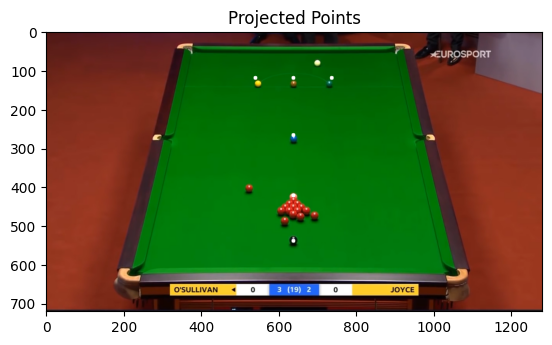

In [117]:
# COMPUTE THE BALL POSITION AND DRAW IT


# first some variable
middle_y = 3.569/2
middle_x = 1.778/2

# (yellow, green, brown, blue, pink, black
points = np.array([
    [middle_x - 0.292, middle_y - 1.0475],  # yellow
    [middle_x + 0.292, middle_y - 1.0475],  # green
    [middle_x, middle_y - 1.0475],          # brown
    [middle_x, middle_y],                   # blue
    [middle_x, middle_y + 0.89225],         # pink
    [middle_x, middle_y + 1.4605]           # black
])


# Apply transformation 

# Like for image but with points
def apply_transformation_to_points(points, M):
    transformed_points = []
    for point in points:
        print(point)
        point_homog = np.array([point[0], point[1], 1])
        transformed_point = np.dot(np.linalg.inv(M), point_homog) 
        transformed_point /= transformed_point[2] 
        transformed_points.append(transformed_point[:2])
    return np.array(transformed_points)

projected_points = apply_transformation_to_points(points, M)


# #################################
# #################################
# JUST VISUALIZATION TO CHECK IF BALLS ARE CORRECT

cv2.destroyAllWindows()
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# draw points
output_image = image_rgb.copy()
for point in projected_points:

    cv2.circle(output_image, (int(point[0]), int(point[1])), 5, (255, 255, 255), -1)


# show image
plt.imshow(output_image)
plt.title('Projected Points')
plt.show()

# #################################
# #################################
# #################################


(917.6169669343741, 33.49728770753996) (360.22281687677474, 33.497287707539996)
(1051.7405259253899, 614.4502476502524) (226.09925788575902, 614.4502476502524)
Area of the table: 401739.26 px^2
Corner Points:
Point 1: (226.10, 614.45)
Point 2: (360.22, 33.50)
Point 3: (917.62, 33.50)
Point 4: (1051.74, 614.45)


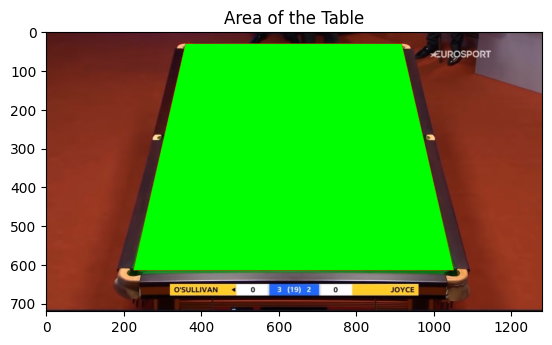

Area of the table: 6.35 m^2
error:  1.4416503901770739e-07


In [119]:
# AREA OF TABLE

# GET THE AREA OF THE TABLE

print(intersection_points_pos[2],intersection_points_pos[1])
print(intersection_points_pos[3],intersection_points_pos[0])
Base_a = intersection_points_pos[2][0]-intersection_points_pos[1][0]
Base_b = intersection_points_pos[3][0]-intersection_points_pos[0][0]
Height = intersection_points_pos[0][1]-intersection_points_pos[1][1]
Area = (Base_a+Base_b)*Height/2

print(f'Area of the table: {Area:.2f} px^2')

# #################################
# #################################
# JUST VISUALIZATION TO CHECK IF AREA IS CORRECT
print('Corner Points:')
for i, point in enumerate(intersection_points_pos):
    print(f'Point {i + 1}: ({point[0]:.2f}, {point[1]:.2f})')

output_image = image_rgb.copy()
for i in range(4):
    cv2.line(output_image, (int(intersection_points_pos[i][0]), int(intersection_points_pos[i][1])), (int(intersection_points_pos[(i + 1) % 4][0]), int(intersection_points_pos[(i + 1) % 4][1])), (255, 0, 0), 2)
    cv2.fillPoly(output_image, np.array([intersection_points_pos], dtype=np.int32), (0, 255, 0, 100))

plt.imshow(output_image)
plt.title('Area of the Table')
plt.show()

# #################################
# #################################


# double check transoform intersection_points_pos with M into normalized coordinates and compute area

# use M convert intersection_points_pos into normalized coordinates
normalized_points = cv2.perspectiveTransform(np.array([intersection_points_pos], dtype=np.float32), M)
# compute the area
Base_a = normalized_points[0][2][0]-normalized_points[0][1][0]
Base_b = normalized_points[0][3][0]-normalized_points[0][0][0]
Height = normalized_points[0][0][1]-normalized_points[0][1][1]
Area = (Base_a+Base_b)*Height/2
print(f'Area of the table: {Area:.2f} m^2')
print("error: ", Area - 3.569*1.778)




